In [1]:
import xclim as xc
import xarray as xr
import glob
from dask.distributed import Client
from matplotlib import pyplot as plt
from xclim.core import dataflags
from xclim.core.units import convert_units_to
import warnings
%matplotlib inline
import dask
import time

input_path = '/tank/jlavoie/ccdp/input/PCIC/'

# build virtual module
ccdp = xc.core.indicator.build_indicator_module_from_yaml("xclim-ccdp/CMIP6/ccdp.yml", mode="raise")

# choose a random psition to look at
random_lat = 256
random_lon = 346
random_year ='2080'
random_time =6457

# POTENTIAL ISSUE 1: weird spatial patterns
I see lines on the map that look unphysical. 

Text(0.5, 0.98, 'day_BCCAQv2+ANUSPLIN300_NorESM2-LM_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr')

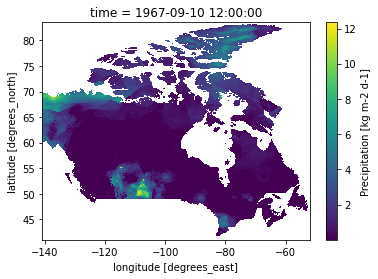

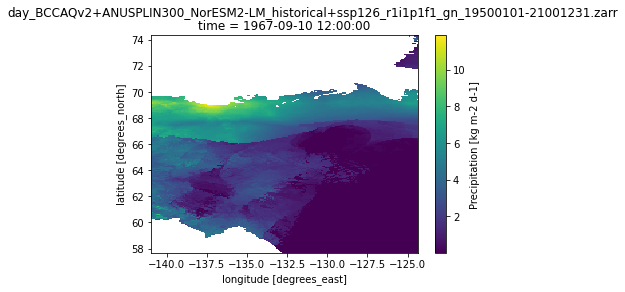

In [2]:
file =f'{input_path}day_BCCAQv2+ANUSPLIN300_NorESM2-LM_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr'
ds = xr.open_mfdataset(file,engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)
ds.pr.isel(time=random_time).plot()
fig=plt.figure()
fig.patch.set_facecolor('white')
ds.pr.isel(time=random_time, lon=slice(0,200), lat=slice(200,400)).plot()
plt.suptitle(file.split('/')[-1])

Text(0.5, 0.98, 'day_BCCAQv2+ANUSPLIN300_CMCC-ESM2_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr')

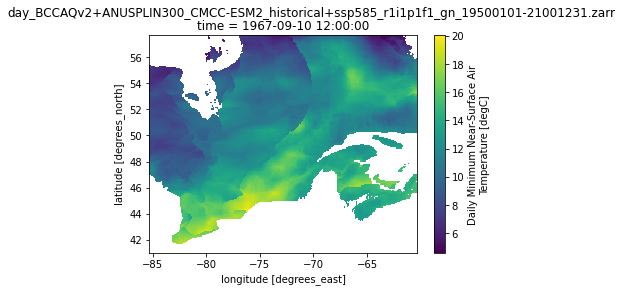

In [3]:
file =f'{input_path}day_BCCAQv2+ANUSPLIN300_CMCC-ESM2_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr'
ds = xr.open_mfdataset(file,engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)
fig=plt.figure()
fig.patch.set_facecolor('white')
ds.tasmin.isel(time=random_time, lon=slice(-400,-100), lat=slice(0,200)).plot()
plt.suptitle(file.split('/')[-1])

Text(0.5, 0.98, 'day_BCCAQv2+ANUSPLIN300_MPI-ESM1-2-LR_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr')

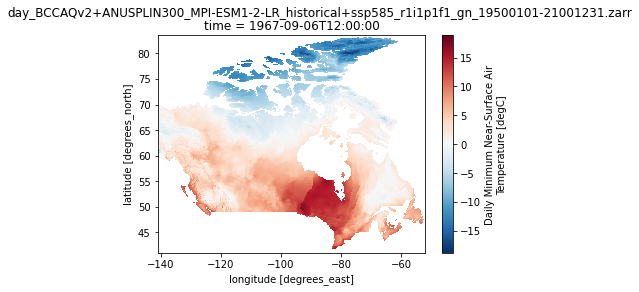

In [4]:
file =f'{input_path}day_BCCAQv2+ANUSPLIN300_MPI-ESM1-2-LR_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr'
ds = xr.open_mfdataset(file,engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)
fig=plt.figure()
fig.patch.set_facecolor('white')
ds.tasmin.isel(time=random_time).plot()
plt.suptitle(file.split('/')[-1])

# Potential issue 2: large pr in Yukon
I see very large daily pr ( around 500-700 kg m-2 d-1) in one spot in the Yukon. It comes back for most model. I think there might have been a mistake in the reference dataset.

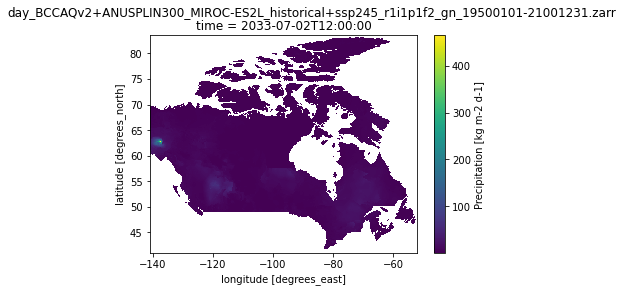

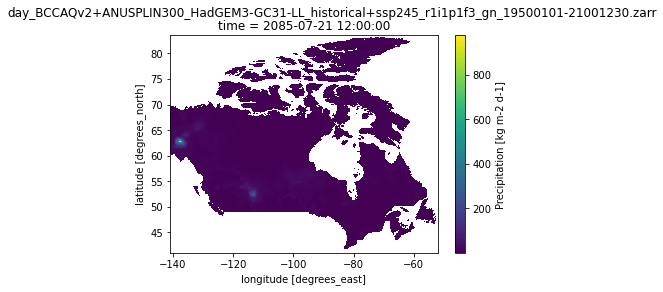

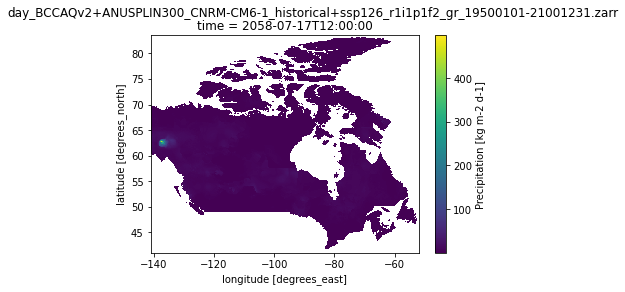

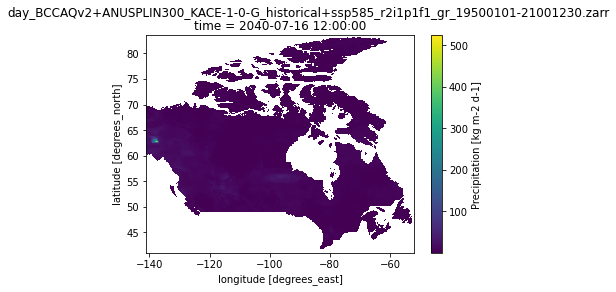

In [5]:
with Client(n_workers=4, threads_per_worker=4, memory_limit="4GB",
                    dashboard_address=6785, local_directory='/exec/jlavoie/', silence_logs=40) as client:
    for file in (glob.glob(f"{input_path}*"))[:4]:
        fig=plt.figure()
        fig.patch.set_facecolor('white')
        ds = xr.open_mfdataset(file,engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)
        ds.pr.isel(time=ds.pr.isel(lon=43, lat=261).argmax().values).plot()
        plt.suptitle(file.split('/')[-1])


# Potential issue 3: large tasmax in HadGEM3-GC31-LL and UKESM1-0-LL (ssp245, ssp585)
The maximum temperature is around 60 degC. This might be fine, but it triggered our health checks (T>60 degC).
For the 2 ssps, the max is not at the same location...

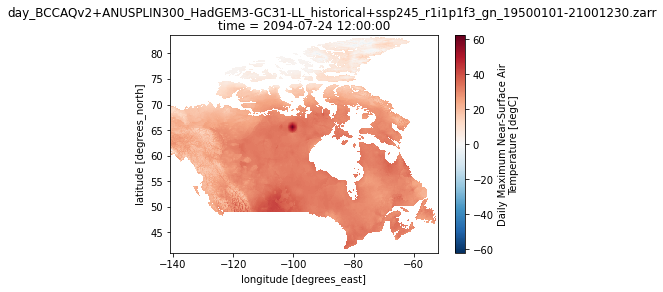

<Figure size 432x288 with 0 Axes>

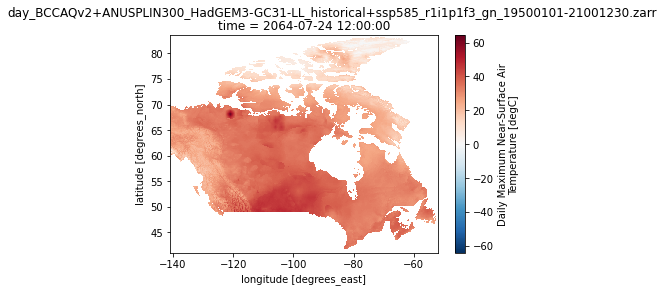

In [6]:
# big tasmax problem
with Client(n_workers=4, threads_per_worker=4, memory_limit="4GB",
                    dashboard_address=6785, local_directory='/exec/jlavoie/', silence_logs=40) as client:
    file =f'{input_path}day_BCCAQv2+ANUSPLIN300_HadGEM3-GC31-LL_historical+ssp245_r1i1p1f3_gn_19500101-21001230.zarr'
    ds = xr.open_mfdataset(file,engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)
    #print(ds.tasmax.isel(lat=295,lon=488).argmax().values)
    fig=plt.figure()
    fig.patch.set_facecolor('white')
    ds.tasmax.isel(time=52043).plot()
    plt.suptitle(file.split('/')[-1])
    
    plt.figure()
    file =f'{input_path}day_BCCAQv2+ANUSPLIN300_HadGEM3-GC31-LL_historical+ssp585_r1i1p1f3_gn_19500101-21001230.zarr'
    ds = xr.open_mfdataset(file,engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)
    #print(ds.tasmax.isel(lat=325,lon=240).argmax().values)
    fig=plt.figure()
    fig.patch.set_facecolor('white')
    ds.tasmax.isel(time=41243).plot()
    plt.suptitle(file.split('/')[-1])

54217
53136


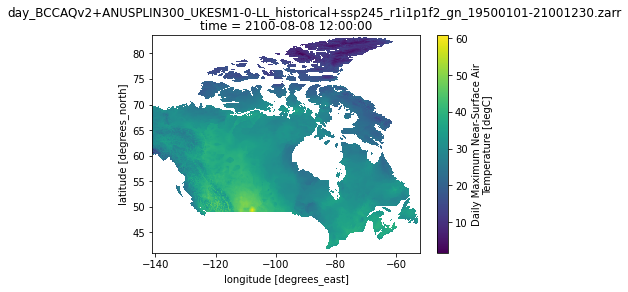

<Figure size 432x288 with 0 Axes>

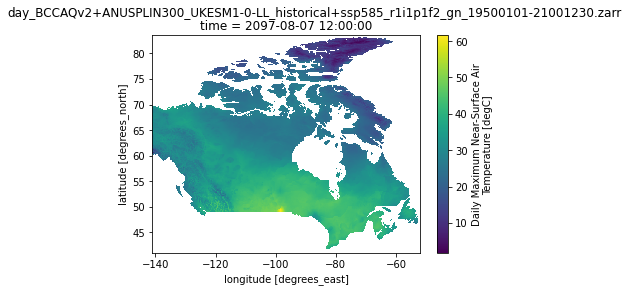

In [7]:
with Client(n_workers=4, threads_per_worker=4, memory_limit="6GB",
                    dashboard_address=6785, local_directory='/exec/jlavoie/', silence_logs=40) as client:
    file =f'{input_path}day_BCCAQv2+ANUSPLIN300_UKESM1-0-LL_historical+ssp245_r1i1p1f2_gn_19500101-21001230.zarr'
    ds = xr.open_dataset(file, engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)
    ind= ds.tasmax.isel(lat=100, lon=398).argmax().values
    print(ind)
    fig=plt.figure()
    fig.patch.set_facecolor('white')
    ds.tasmax.isel(time=54217).plot()
    plt.suptitle(file.split('/')[-1])
    
    plt.figure()
    file =f'{input_path}day_BCCAQv2+ANUSPLIN300_UKESM1-0-LL_historical+ssp585_r1i1p1f2_gn_19500101-21001230.zarr'
    ds = xr.open_dataset(file, engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)
    ind= ds.tasmax.isel(lat=99,lon=510).argmax().values
    fig=plt.figure()
    fig.patch.set_facecolor('white')
    print(ind)
    ds.tasmax.isel(time=53136).plot()
    plt.suptitle(file.split('/')[-1])

# visual inspection of tasmax, tasmin, pr
for all models and ssps: map at 1 time and time series at 1 location

/exec/jlavoie/.conda/ccdp/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


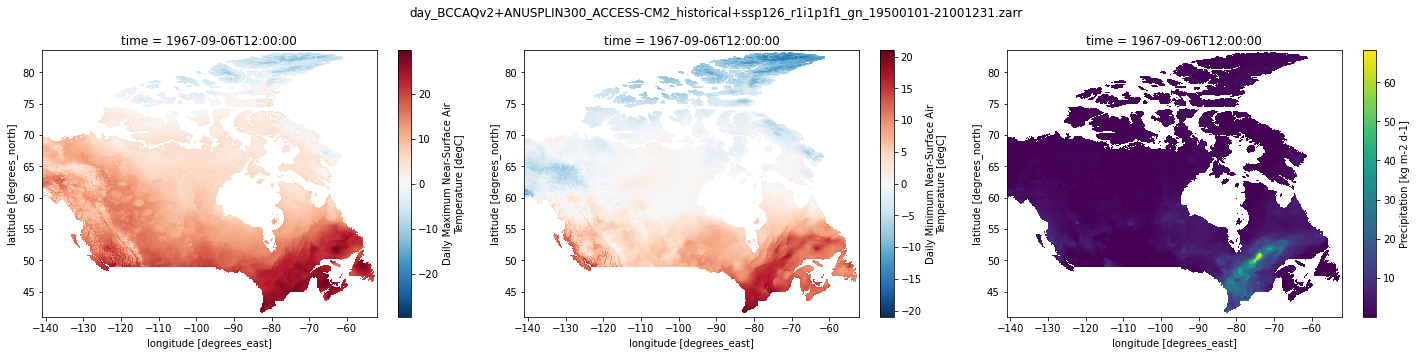

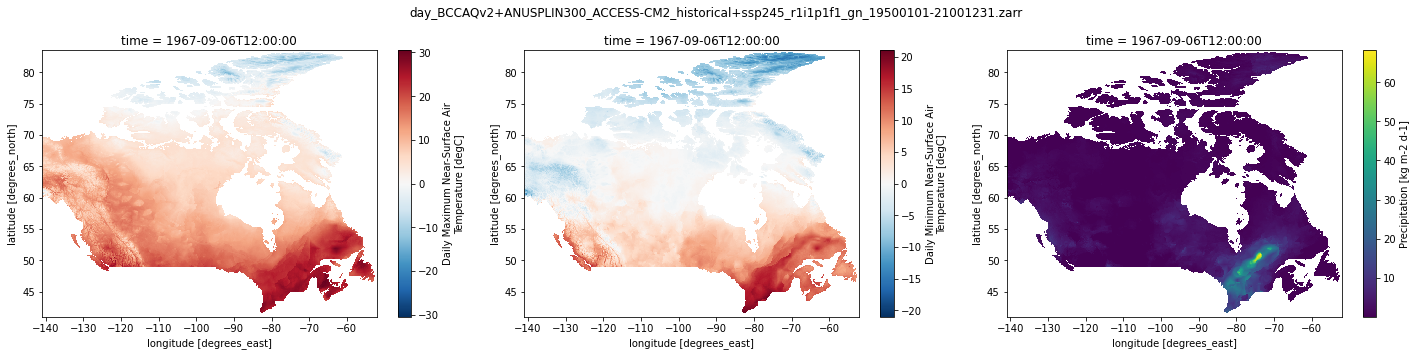

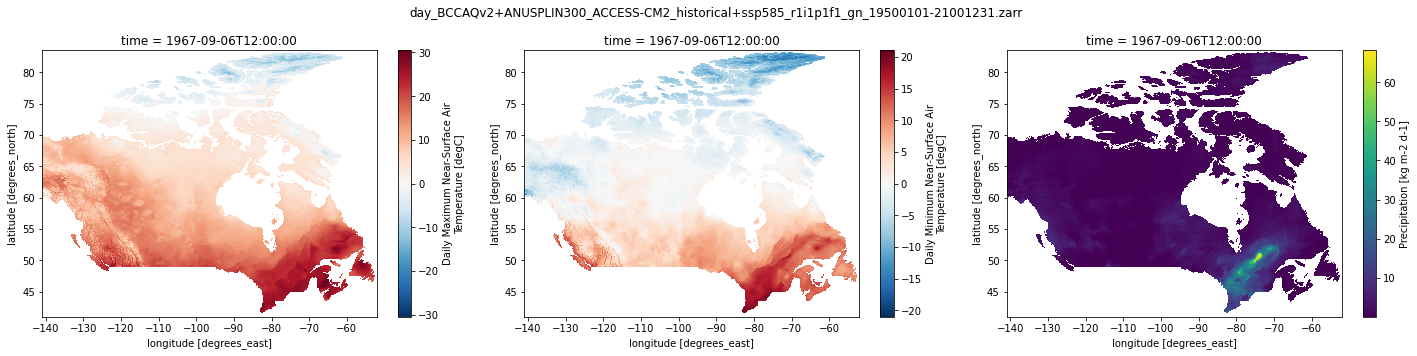

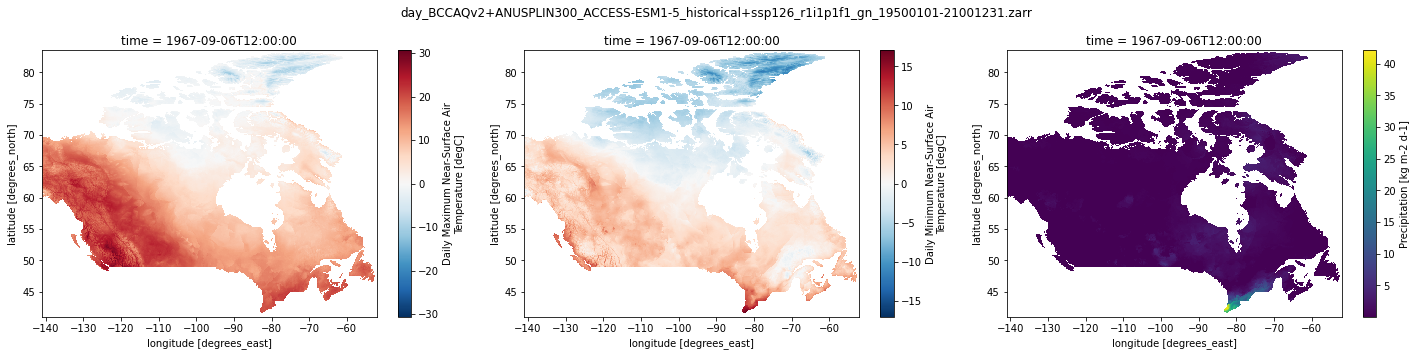

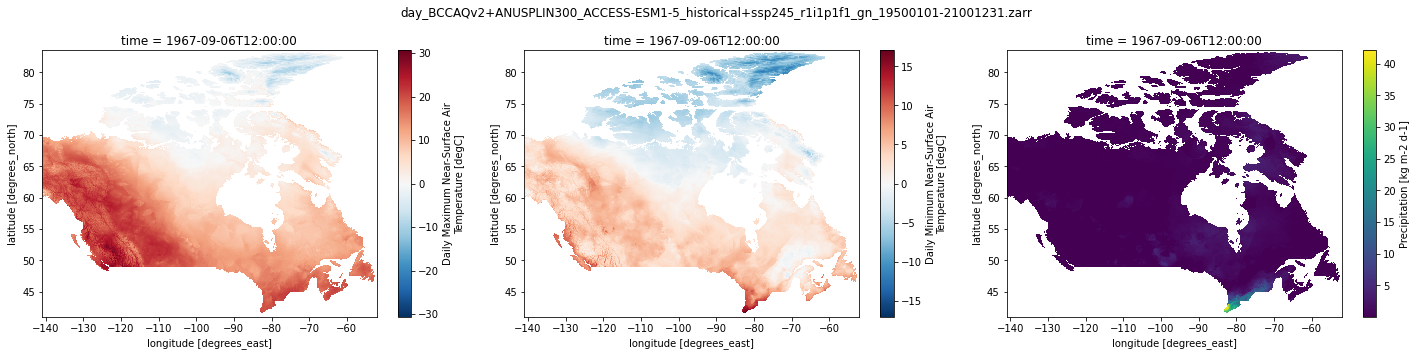

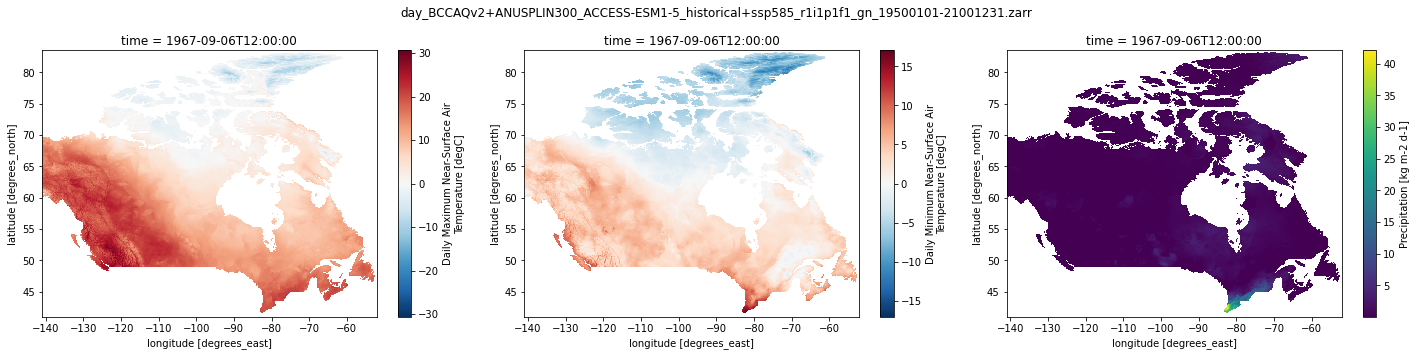

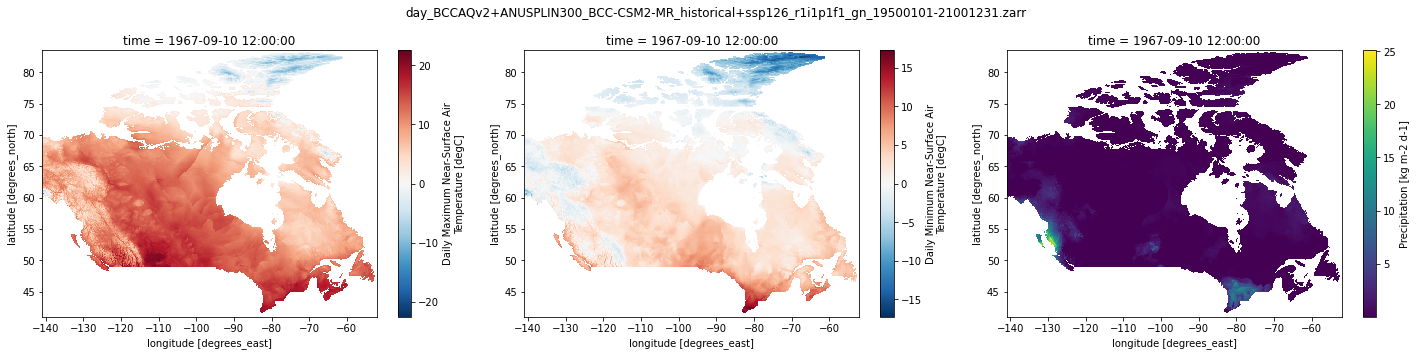

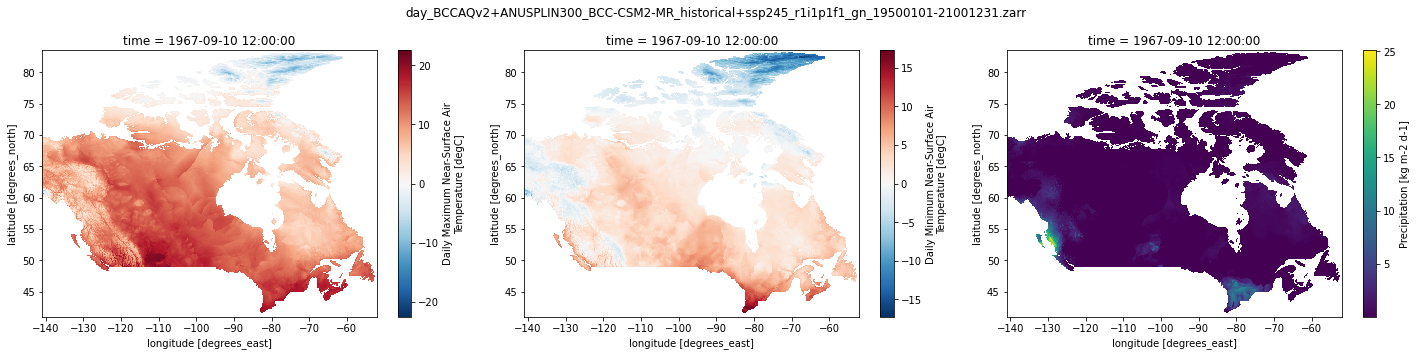

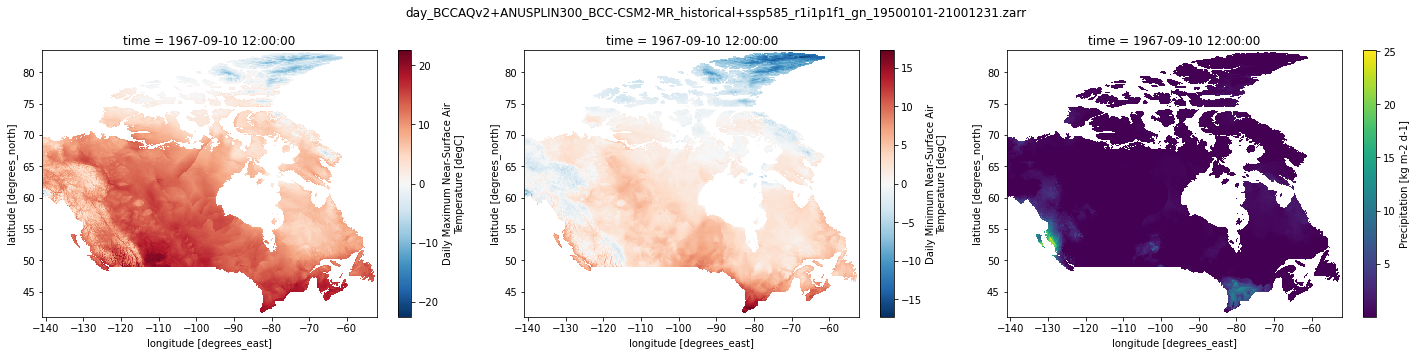

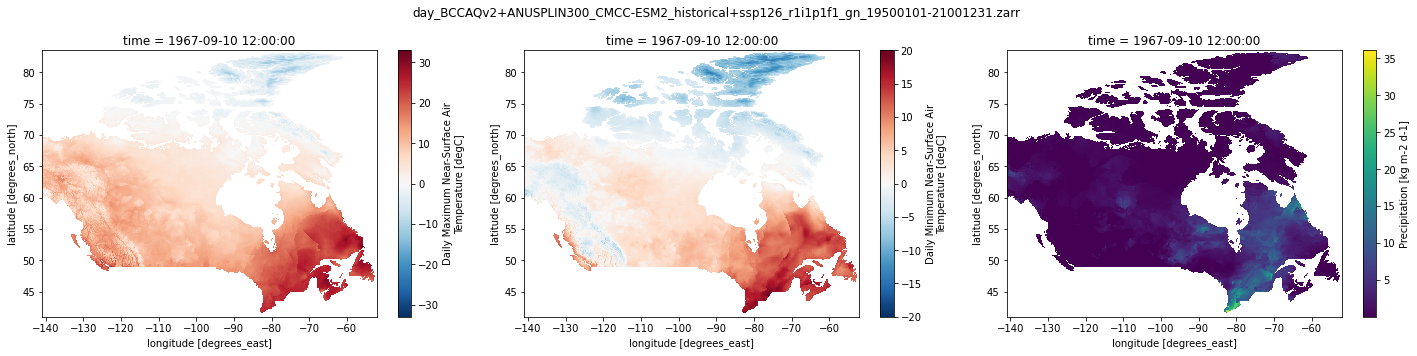

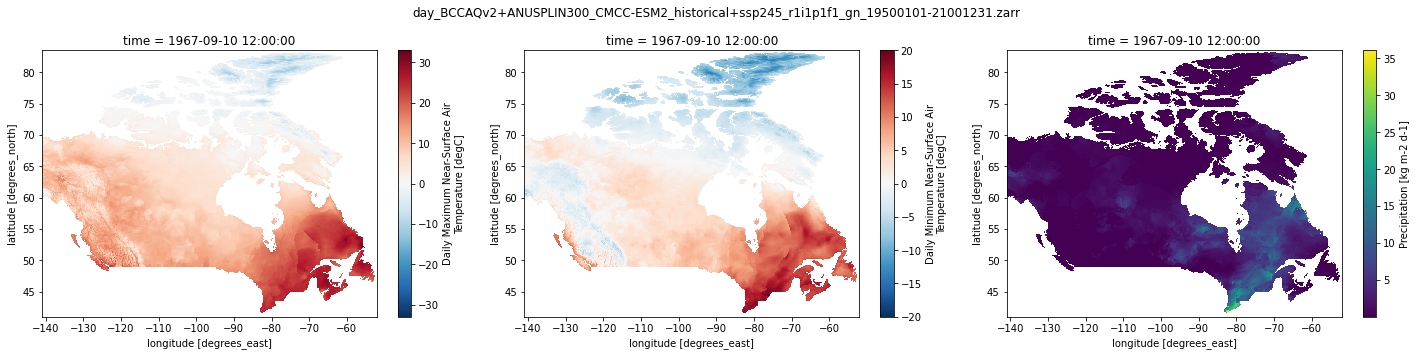

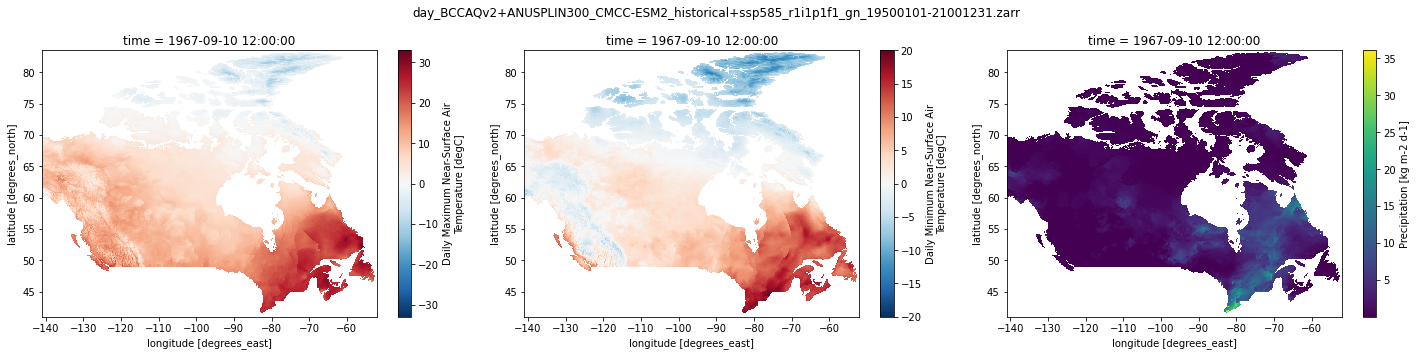

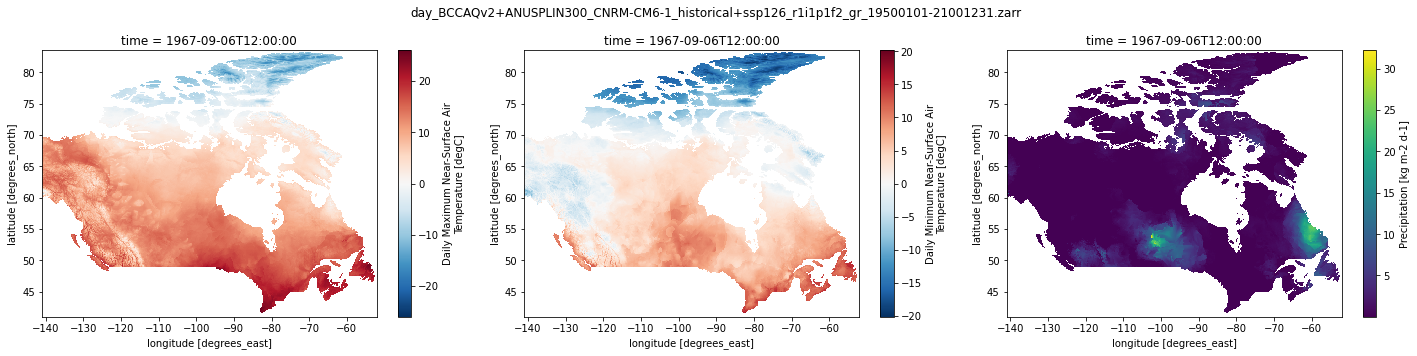

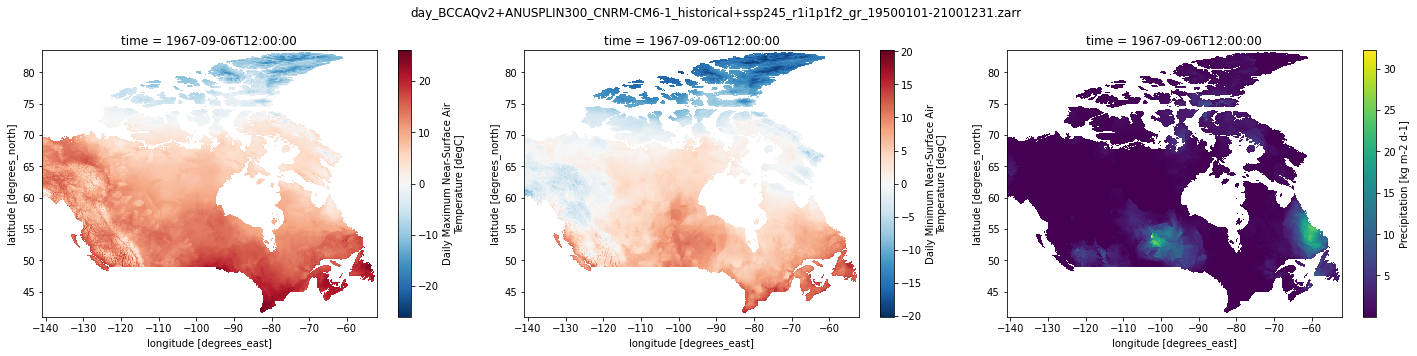

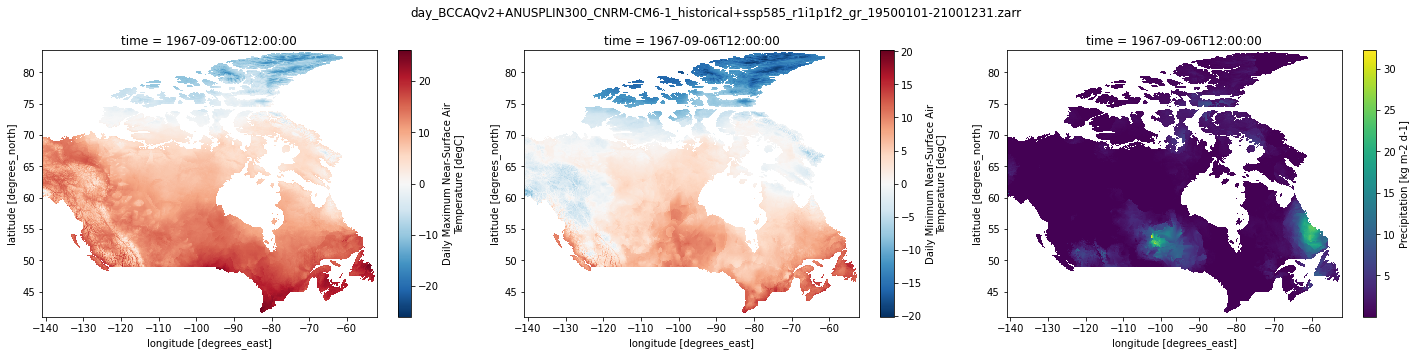

In [ ]:
with Client(n_workers=4, threads_per_worker=4, memory_limit="6GB",
                    dashboard_address=6785, local_directory='/exec/jlavoie/', silence_logs=40) as client:
    for file in sorted(glob.glob(f"{input_path}*")[:]):
        #print(file.split('/')[-1])
        ds = xr.open_mfdataset(file,engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)
        #display(ds)
        #fig1, axs1 = plt.subplots(3,1, figsize=(20,10))
        # commented out the timeseries plots because the notebook was too heavy to upload on github with those 
        fig2, axs2 = plt.subplots(1,3, figsize=(20,5))
        for i,var in enumerate(['tasmax', 'tasmin','pr']):
            #ds[var].isel(lat=random_lat, lon=random_lon).plot(ax=axs1[i])
            ds[var].isel(time=random_time).plot(ax=axs2[i])
        fig2.suptitle(file.split('/')[-1])
        fig2.tight_layout()

# visual inspection of indicators
not plotted here to avoid very heavy notebook, but all looks ok

In [ ]:
with Client(n_workers=4, threads_per_worker=4, memory_limit="4GB",
                    dashboard_address=6785, local_directory='/exec/jlavoie/', silence_logs=40) as client:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            for name, ind in ccdp.iter_indicators():
                if name not in ['tg_mean','gddgrow_0','last_spring_frost','first_fall_frost','frost_free_season']: # tas not calculated yet
                #if name == 'tnlt_m15':
                    print(name)
                    fig1, axs1 = plt.subplots(26,3, figsize=(20,75),sharey=True)
                    axs1= axs1.ravel()
                    fig2, axs2 = plt.subplots(26,3, figsize=(20,26*4))
                    axs2= axs2.ravel()
                    for i,file in enumerate(sorted(glob.glob(f"{input_path}*")[:])):
                        #print(file)
                        ds = xr.open_mfdataset(file,engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)

                        ds=ds.sel(time="2050")
                        out1=ind(ds=ds.isel(lat=random_lat, lon=random_lon), freq='MS')
                        out1.plot(ax=axs1[i])
                        out2=ind(ds=ds.sel(time="2050-04"), freq='MS')
                        out2.plot(ax=axs2[i])
                        axs1[i].set_title(file[52:-22])
                        axs2[i].set_title(file[52:-22])
                    fig1.tight_layout()
                    fig2.tight_layout()

In [ ]:
with Client(n_workers=6, threads_per_worker=4, memory_limit="4GB",
                    dashboard_address=6785, local_directory='/exec/jlavoie/', silence_logs=40) as client:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            for name, ind in ccdp.iter_indicators():
                if name in ['last_spring_frost','first_fall_frost','frost_free_season']:
                    print(name)
                    fig2, axs2 = plt.subplots(26,3, figsize=(20,26*4))
                    axs2= axs2.ravel()
                    for i,file in enumerate(sorted(glob.glob(f"{input_path}*")[:])):
                        print(i)
                        #print(file)
                        ds = xr.open_mfdataset(file,engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)
                        ds = ds.sel(time="2050")
                        out2=ind(ds=ds)
                        out2.plot(ax=axs2[i])
                        axs2[i].set_title(file[52:-22])
                    fig2.tight_layout()

# health checks

In [ ]:
nb_point=510*1068*55152
with Client(n_workers=4, threads_per_worker=4, memory_limit="6GB",
                    dashboard_address=6785, local_directory='/exec/jlavoie/', silence_logs=40) as client:
    for file in sorted(glob.glob(f"{input_path}*"))[56:]:
        print(file)
        ds = xr.open_mfdataset(file,engine='zarr',chunks={'time': 365, 'lat': 64, 'lon': 64},decode_timedelta=False)

        test1 = []
        for var in ['tasmax', 'tasmin','pr']:
            test1.append(xc.core.datachecks.check_daily(ds[var]))
        print('check_daily', test1)

        test3 = dataflags.negative_accumulation_values(ds.pr)
        print("negative_accumulation_values", test3.sum().values/nb_point)
        test5 = dataflags.temperature_extremely_high(ds.tasmax)
        print("temperature_extremely_high",test5.sum().values/nb_point)
        test6 = dataflags.temperature_extremely_low(ds.tasmin)
        print("temperature_extremely_low",test6.sum().values/nb_point)
        test7 = dataflags.very_large_precipitation_events(ds.pr)
        print("very_large_precipitation_events",test7.sum().values/nb_point)
        print('')

In [ ]:
#output of above:
day_BCCAQv2+ANUSPLIN300_ACCESS-CM2_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 2.6431256395298808e-08

day_BCCAQv2+ANUSPLIN300_ACCESS-CM2_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 3.162429921351873e-08

day_BCCAQv2+ANUSPLIN300_ACCESS-CM2_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 5.0965054837786495e-08

day_BCCAQv2+ANUSPLIN300_ACCESS-ESM1-5_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.3681670501848627e-08

day_BCCAQv2+ANUSPLIN300_ACCESS-ESM1-5_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.7842762503627407e-08

day_BCCAQv2+ANUSPLIN300_ACCESS-ESM1-5_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 2.3069094057861555e-08

day_BCCAQv2+ANUSPLIN300_BCC-CSM2-MR_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.0419374372454064e-08

day_BCCAQv2+ANUSPLIN300_BCC-CSM2-MR_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 2.2603051753662332e-08

day_BCCAQv2+ANUSPLIN300_BCC-CSM2-MR_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 2.8495158028181083e-08

day_BCCAQv2+ANUSPLIN300_CMCC-ESM2_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.5279529830531677e-08

day_BCCAQv2+ANUSPLIN300_CMCC-ESM2_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 7.123789507045271e-09

day_BCCAQv2+ANUSPLIN300_CMCC-ESM2_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.980679792846699e-08

day_BCCAQv2+ANUSPLIN300_CNRM-CM6-1_historical+ssp126_r1i1p1f2_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 6.924057090959889e-09

day_BCCAQv2+ANUSPLIN300_CNRM-CM6-1_historical+ssp245_r1i1p1f2_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.0685684260567906e-08

day_BCCAQv2+ANUSPLIN300_CNRM-CM6-1_historical+ssp585_r1i1p1f2_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.4480600166190153e-08

day_BCCAQv2+ANUSPLIN300_CNRM-ESM2-1_historical+ssp126_r1i1p1f2_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 5.725662594447601e-09

day_BCCAQv2+ANUSPLIN300_CNRM-ESM2-1_historical+ssp245_r1i1p1f2_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.0386085636439834e-08

day_BCCAQv2+ANUSPLIN300_CNRM-ESM2-1_historical+ssp585_r1i1p1f2_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 2.2969227849818863e-08

day_BCCAQv2+ANUSPLIN300_CanESM5_historical+ssp126_r1i1p2f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.0918705412667517e-08

day_BCCAQv2+ANUSPLIN300_CanESM5_historical+ssp245_r1i1p2f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 8.821515043771012e-09

day_BCCAQv2+ANUSPLIN300_CanESM5_historical+ssp585_r1i1p2f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.4513888902204383e-08

day_BCCAQv2+ANUSPLIN300_EC-Earth3-Veg_historical+ssp126_r1i1p1f1_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.25498534773648e-08

day_BCCAQv2+ANUSPLIN300_EC-Earth3-Veg_historical+ssp245_r1i1p1f1_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.537939603857437e-08


day_BCCAQv2+ANUSPLIN300_EC-Earth3-Veg_historical+ssp585_r1i1p1f1_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 2.5965214091099585e-08

day_BCCAQv2+ANUSPLIN300_EC-Earth3_historical+ssp126_r4i1p1f1_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.554583971864552e-08

day_BCCAQv2+ANUSPLIN300_EC-Earth3_historical+ssp245_r4i1p1f1_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 8.48862768362871e-09

day_BCCAQv2+ANUSPLIN300_EC-Earth3_historical+ssp585_r4i1p1f1_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.4880064998360916e-08

day_BCCAQv2+ANUSPLIN300_FGOALS-g3_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 8.122451587472177e-09

day_BCCAQv2+ANUSPLIN300_FGOALS-g3_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.3015895781564022e-08

day_BCCAQv2+ANUSPLIN300_FGOALS-g3_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.394798038996247e-08

day_BCCAQv2+ANUSPLIN300_GFDL-ESM4_historical+ssp126_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 6.691035938860278e-09

day_BCCAQv2+ANUSPLIN300_GFDL-ESM4_historical+ssp245_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 6.158416162632594e-09

day_BCCAQv2+ANUSPLIN300_GFDL-ESM4_historical+ssp585_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 4.5272680979353126e-09

day_BCCAQv2+ANUSPLIN300_HadGEM3-GC31-LL_historical+ssp126_r1i1p1f3_gn_19500101-21001230.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.8708269639997393e-08

day_BCCAQv2+ANUSPLIN300_HadGEM3-GC31-LL_historical+ssp245_r1i1p1f3_gn_19500101-21001230.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 1.9973241608538142e-10
temperature_extremely_low 0.0
very_large_precipitation_events 4.1544342545759337e-08

day_BCCAQv2+ANUSPLIN300_HadGEM3-GC31-LL_historical+ssp585_r1i1p1f3_gn_19500101-21001230.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 1.9307466888253536e-09
temperature_extremely_low 0.0
very_large_precipitation_events 8.701675594119784e-08

day_BCCAQv2+ANUSPLIN300_INM-CM4-8_historical+ssp126_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.4147712806047851e-08

day_BCCAQv2+ANUSPLIN300_INM-CM4-8_historical+ssp245_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 8.55520515565717e-09

day_BCCAQv2+ANUSPLIN300_INM-CM4-8_historical+ssp585_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.7776185031598947e-08

day_BCCAQv2+ANUSPLIN300_INM-CM5-0_historical+ssp126_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.2383409797293648e-08

day_BCCAQv2+ANUSPLIN300_INM-CM5-0_historical+ssp245_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.25498534773648e-08

day_BCCAQv2+ANUSPLIN300_INM-CM5-0_historical+ssp585_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.5046508678432066e-08

day_BCCAQv2+ANUSPLIN300_IPSL-CM6A-LR_historical+ssp126_r1i1p1f1_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.1784212549037503e-08

day_BCCAQv2+ANUSPLIN300_IPSL-CM6A-LR_historical+ssp245_r1i1p1f1_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.1085149092738669e-08

day_BCCAQv2+ANUSPLIN300_IPSL-CM6A-LR_historical+ssp585_r1i1p1f1_gr_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.544597351060283e-08

day_BCCAQv2+ANUSPLIN300_KACE-1-0-G_historical+ssp126_r2i1p1f1_gr_19500101-21001230.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.0785550468610597e-08

day_BCCAQv2+ANUSPLIN300_KACE-1-0-G_historical+ssp245_r2i1p1f1_gr_19500101-21001230.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 2.3235537737932707e-08

day_BCCAQv2+ANUSPLIN300_KACE-1-0-G_historical+ssp585_r2i1p1f1_gr_19500101-21001230.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 4.077870161743204e-08

day_BCCAQv2+ANUSPLIN300_KIOST-ESM_historical+ssp126_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 9.78688838818369e-09

day_BCCAQv2+ANUSPLIN300_KIOST-ESM_historical+ssp245_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.4314156486119001e-08

day_BCCAQv2+ANUSPLIN300_KIOST-ESM_historical+ssp585_r1i1p1f1_gr1_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 2.2802784169747712e-08

day_BCCAQv2+ANUSPLIN300_MIROC-ES2L_historical+ssp126_r1i1p1f2_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 7.1903669790737315e-09

day_BCCAQv2+ANUSPLIN300_MIROC-ES2L_historical+ssp245_r1i1p1f2_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 6.091838690604133e-09

day_BCCAQv2+ANUSPLIN300_MIROC-ES2L_historical+ssp585_r1i1p1f2_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.6278191910958587e-08

day_BCCAQv2+ANUSPLIN300_MIROC6_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 9.287557347970237e-09

day_BCCAQv2+ANUSPLIN300_MIROC6_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 7.2569444511021914e-09

day_BCCAQv2+ANUSPLIN300_MIROC6_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.4913353734375146e-08

day_BCCAQv2+ANUSPLIN300_MPI-ESM1-2-HR_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 4.1610920017787795e-09

day_BCCAQv2+ANUSPLIN300_MPI-ESM1-2-HR_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 5.226331554234147e-09

day_BCCAQv2+ANUSPLIN300_MPI-ESM1-2-HR_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.0419374372454064e-08

day_BCCAQv2+ANUSPLIN300_MPI-ESM1-2-LR_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 5.093176610177226e-09

day_BCCAQv2+ANUSPLIN300_MPI-ESM1-2-LR_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 7.02392329900258e-09

day_BCCAQv2+ANUSPLIN300_MPI-ESM1-2-LR_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.6145036966901663e-08

day_BCCAQv2+ANUSPLIN300_MPI-ESM1-2-LR_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.6145036966901663e-08

day_BCCAQv2+ANUSPLIN300_MRI-ESM2-0_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 6.025261218575673e-09

day_BCCAQv2+ANUSPLIN300_MRI-ESM2-0_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.6211614438930127e-08

day_BCCAQv2+ANUSPLIN300_MRI-ESM2-0_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 9.953332068254841e-09

day_BCCAQv2+ANUSPLIN300_NorESM2-LM_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.1850790021065965e-08

day_BCCAQv2+ANUSPLIN300_NorESM2-LM_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.551255098263129e-08

day_BCCAQv2+ANUSPLIN300_NorESM2-LM_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.2150388645194036e-08

day_BCCAQv2+ANUSPLIN300_NorESM2-MM_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 6.424726050746435e-09

day_BCCAQv2+ANUSPLIN300_NorESM2-MM_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.0019909540283301e-08

day_BCCAQv2+ANUSPLIN300_NorESM2-MM_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.3681670501848627e-08

day_BCCAQv2+ANUSPLIN300_TaiESM1_historical+ssp126_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.2882740837507102e-08

day_BCCAQv2+ANUSPLIN300_TaiESM1_historical+ssp245_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.401455786199093e-08

day_BCCAQv2+ANUSPLIN300_TaiESM1_historical+ssp585_r1i1p1f1_gn_19500101-21001231.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 3.3288736014230236e-08

day_BCCAQv2+ANUSPLIN300_UKESM1-0-LL_historical+ssp126_r1i1p1f2_gn_19500101-21001230.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 0.0
temperature_extremely_low 0.0
very_large_precipitation_events 1.6078459494873203e-08

day_BCCAQv2+ANUSPLIN300_UKESM1-0-LL_historical+ssp245_r1i1p1f2_gn_19500101-21001230.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 6.657747202846047e-11
temperature_extremely_low 0.0
very_large_precipitation_events 1.5912015814802052e-08

day_BCCAQv2+ANUSPLIN300_UKESM1-0-LL_historical+ssp585_r1i1p1f2_gn_19500101-21001230.zarr
check_daily [None, None, None]
negative_accumulation_values 0.0
temperature_extremely_high 1.2316832325265187e-09
temperature_extremely_low 0.0
very_large_precipitation_events 4.4340596370954675e-08